In [172]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()
last_complete_month = '2020-06-30'
last_complete_week = pd.Timestamp(last_complete_month).week

# last complete week may be a few days off... but we are not doing rocket science here,
# no need for precision to nth decimal... let's subtract one week for the 2015-2019 baseline,
# so we are not getting positive bias for 2020

last_complete_week -= 1

last_complete_week

26

In [173]:
# https://www.healthknowledge.org.uk/e-learning/epidemiology/specialists/standardisation

# fake data


df = pd.DataFrame({'age_grp': ['inf','inf','child','child','adult','adult','old','old'],
                  'country' : ['A','B','A','B','A','B','A','B'],
                  'pop' : [1000000,1000000,6000000,1500000,5500000,550000,2500000,120000],
                  'dead' : [1000,1000,7000,6300,20000,3000,120000,6000]})

#df['age_grp'] = pd.Categorical(df['age_grp'],['inf','child','adult','old'])

df

,age_grp,country,pop,dead
0,inf,A,1000000,1000
1,inf,B,1000000,1000
2,child,A,6000000,7000
3,child,B,1500000,6300
4,adult,A,5500000,20000
5,adult,B,550000,3000
6,old,A,2500000,120000
7,old,B,120000,6000


In [174]:
### prep for pymc

def age_encode(x):
    if x == 'inf' : return 1
    if x == 'child' : return 2
    if x == 'adult' : return 3
    if x == 'old' : return 4
    
def country_encode(x):
    if x == 'A' : return 1
    if x == 'B' : return 2

    
df['age_idx'] = df['age_grp'].apply(age_encode).astype(int)
df['country_index'] = df['country'].apply(country_encode)
df

,age_grp,country,pop,dead,age_idx,country_index
0,inf,A,1000000,1000,1,1
1,inf,B,1000000,1000,1,2
2,child,A,6000000,7000,2,1
3,child,B,1500000,6300,2,2
4,adult,A,5500000,20000,3,1
5,adult,B,550000,3000,3,2
6,old,A,2500000,120000,4,1
7,old,B,120000,6000,4,2


In [175]:
pivot = pd.pivot(df,columns='age_grp',index='country',values=['pop','dead'])
pivot[('pop','all')] = pivot['pop'].sum(axis=1)
pivot[('dead','all')] = pivot['dead'].sum(axis=1)

mortality = pivot['dead'] / pivot['pop']

pivot


pop                              dead                      \
age_grp    adult    child      inf      old  adult child   inf     old   
country                                                                  
A        5500000  6000000  1000000  2500000  20000  7000  1000  120000   
B         550000  1500000  1000000   120000   3000  6300  1000    6000   

              pop    dead  
age_grp       all     all  
country                    
A        15000000  148000  
B         3170000   16300

In [176]:
pct_pop_age_grp = pivot['pop'].loc[:,'adult' : 'old'].div(pivot[('pop','all')],axis=0)
pct_pop_age_grp

age_grp,adult,child,inf,old
country,,,,
A,0.366667,0.400000,0.066667,0.166667
B,0.173502,0.473186,0.315457,0.037855


In [177]:
mortality

age_grp,adult,child,inf,old,all
country,,,,,
A,0.003636,0.001167,0.001,0.048,0.009867
B,0.005455,0.004200,0.001,0.050,0.005142


In [178]:
def logit_pure(x):
    return (np.exp(x)) / (1 + np.exp(x))

def logistic_pure(p):
    return np.log(p / (1 - p))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha[0] -4.22  0.53   -5.13    -3.57       0.26      0.2      4.08    4.07   
alpha[1] -3.52  0.53   -4.41    -2.85       0.26      0.2      4.07    4.06   
alpha[2] -2.70  0.53   -3.61    -2.04       0.26      0.2      4.07    4.06   
alpha[3] -0.09  0.53   -0.99     0.57       0.26      0.2      4.07    4.07   
beta[0]  -2.91  0.53   -3.58    -2.02       0.26      0.2      4.07    4.07   
beta[1]  -2.49  0.53   -3.16    -1.60       0.26      0.2      4.07    4.07   

          ess_bulk  ess_tail  r_hat  
alpha[0]      4.58     21.73   2.93  
alpha[1]      4.56     23.88   2.97  
alpha[2]      4.56     23.89   2.97  
alpha[3]      4.56     23.74   2.98  
beta[0]       4.56     23.75   2.98  
beta[1]       4.56     23.78   2.97  


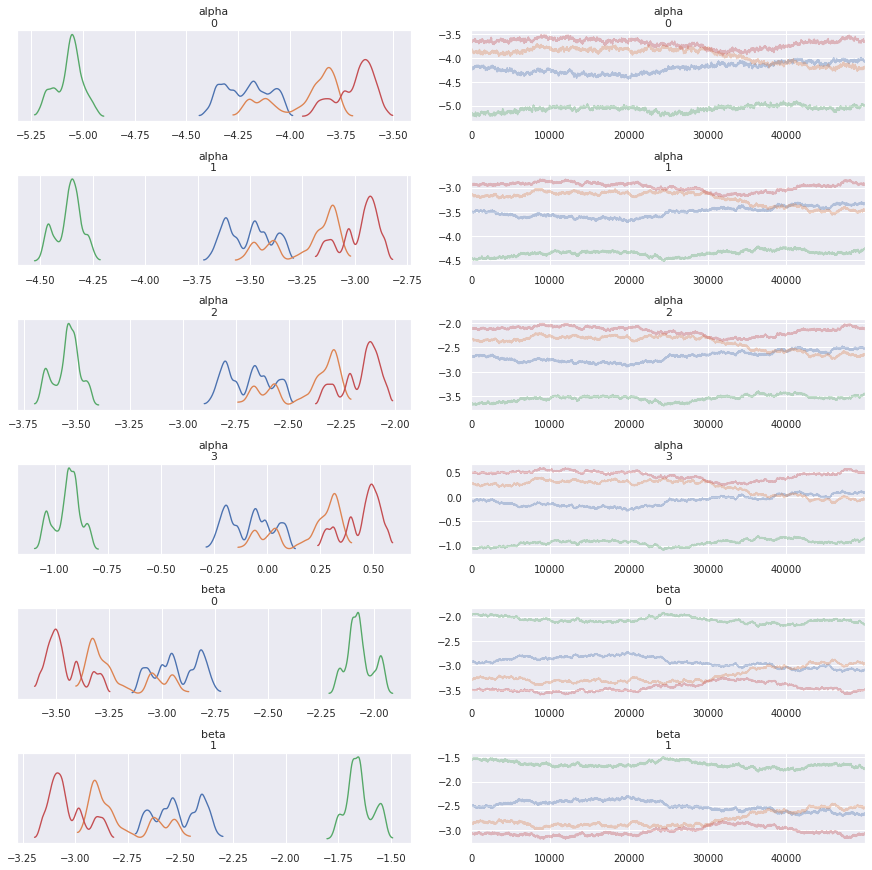

In [179]:
import pymc3 as pm
import arviz as az


### control for age_grp by assigning a unique alpha to each age_grp,
# control for year/country by a unique beta per year/country

# model: 
# dead ~ Binomial(population,p)
# p = logit(alpha[age_idx] + beta[country_idx])
# alpha[age_idx] ~ Normal(0,10)
# beta[country_idx] ~ Normal(0,10)

age_idx = df['age_idx']
country_idx = df['country_index']

model = pm.Model()

with model:

    alpha = pm.Normal('alpha',0, sd=1,shape=4) #4 age groups

    beta = pm.Normal('beta',0,sd=1,shape=2) # two countries

    

    # index for alpha : subtract 1 from age_idx that goes 1..4 to get zero-based index of python

    logit_age = np.exp(alpha[age_idx-1]+beta[country_idx-1]) / (1 + np.exp(alpha[age_idx-1]+beta[country_idx-1]))

    lkh_age = pm.Binomial('lkh_age',n=df['pop'],p=logit_age,observed=df['dead'])   
    
    step1 = pm.Metropolis([alpha,beta])

    trace = pm.sample(50000,step1,tune=10000,chains=4,cores=4)
    
    _= az.plot_trace(trace)
    print (az.summary(trace,round_to=2))
    
    

In [180]:
alpha_inf = trace['alpha'][:,0]
alpha_child = trace['alpha'][:,1]
alpha_adult = trace['alpha'][:,2]
alpha_old = trace['alpha'][:,3]

beta_A = trace['beta'][:,0]
beta_B = trace['beta'][:,1]


result = pd.DataFrame({'alpha_inf' : alpha_inf,
                        'alpha_child' : alpha_child,
                      'alpha_adult' : alpha_adult,
                       'alpha_old' : alpha_old,
                      'beta_A' : beta_A,
                      'beta_B' : beta_B})

result.describe()

,alpha_inf,alpha_child,alpha_adult,alpha_old,beta_A,beta_B
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,-4.222345,-3.517649,-2.699989,-0.093599,-2.914913,-2.494142
std,0.533111,0.533059,0.533361,0.533231,0.533231,0.533240
min,-5.234866,-4.527641,-3.698345,-1.093967,-3.600442,-3.192851
25%,-4.553711,-3.844622,-3.022540,-0.413145,-3.338195,-2.918307
50%,-4.103981,-3.395807,-2.578318,0.027465,-3.036144,-2.614598
75%,-3.793263,-3.094004,-2.276414,0.329893,-2.596383,-2.174327
max,-3.502235,-2.819993,-2.009513,0.592121,-1.913994,-1.491430


In [181]:
p_result = pd.DataFrame()

p_result['A_inf_p'] = logit_pure(result['alpha_inf'] + result['beta_A'])
p_result['A_child_p'] = logit_pure(result['alpha_child'] + result['beta_A'])
p_result['A_adult_p'] = logit_pure(result['alpha_adult'] + result['beta_A'])
p_result['A_old_p'] = logit_pure(result['alpha_old'] + result['beta_A'])


p_result['B_inf_p'] = logit_pure(result['alpha_inf'] + result['beta_B'])
p_result['B_child_p'] = logit_pure(result['alpha_child'] + result['beta_B'])
p_result['B_adult_p'] = logit_pure(result['alpha_adult'] + result['beta_B'])
p_result['B_old_p'] = logit_pure(result['alpha_old'] + result['beta_B'])

In [182]:
p_result.describe()

,A_inf_p,A_child_p,A_adult_p,A_old_p,B_inf_p,B_child_p,B_adult_p,B_old_p
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.000795,0.001606,0.003630,0.047043,0.001210,0.002444,0.005519,0.069934
std,0.000018,0.000014,0.000024,0.000132,0.000027,0.000026,0.000055,0.000564
min,0.000730,0.001544,0.003516,0.046483,0.001105,0.002335,0.005281,0.067355
25%,0.000782,0.001596,0.003614,0.046954,0.001191,0.002426,0.005481,0.069554
50%,0.000794,0.001606,0.003630,0.047043,0.001209,0.002444,0.005519,0.069933
75%,0.000807,0.001615,0.003646,0.047132,0.001228,0.002461,0.005556,0.070316
max,0.000867,0.001674,0.003733,0.047686,0.001322,0.002550,0.005743,0.072450


In [183]:
mortality

age_grp,adult,child,inf,old,all
country,,,,,
A,0.003636,0.001167,0.001,0.048,0.009867
B,0.005455,0.004200,0.001,0.050,0.005142


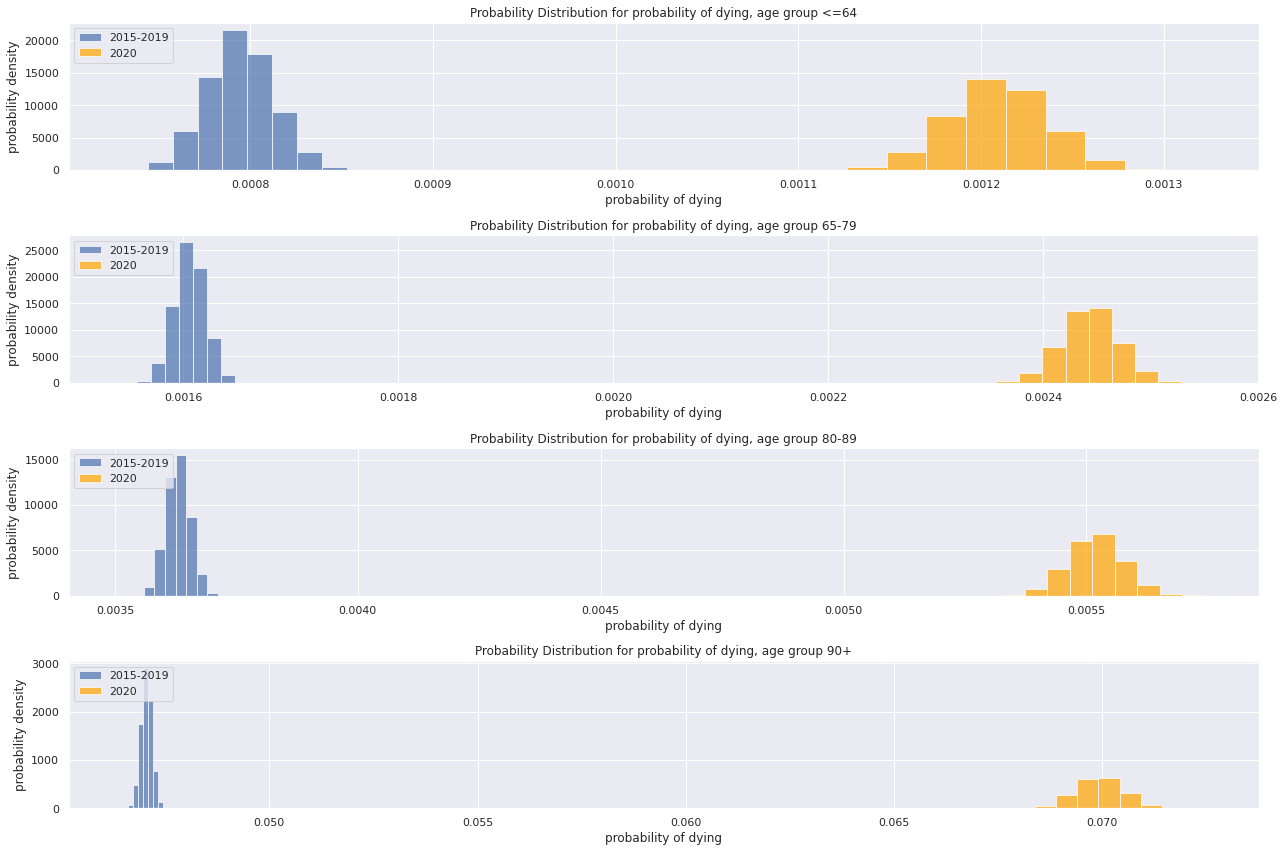

In [184]:
plt.figure(figsize=(18,12))

plt.subplot(411)
plt.title('Probability Distribution for probability of dying, age group <=64')
plt.hist(p_result.A_inf_p,density=True,color='b',alpha=0.7,label='2015-2019')
plt.hist(p_result.B_inf_p,density=True,color='orange',alpha=0.7,label='2020')
plt.xlabel('probability of dying')
plt.ylabel('probability density')
plt.legend(loc='upper left')

plt.subplot(412)
plt.title('Probability Distribution for probability of dying, age group 65-79')

plt.hist(p_result.A_child_p,density=True,color='b',alpha=0.7,label='2015-2019')
plt.hist(p_result.B_child_p,density=True,color='orange',alpha=0.7,label='2020')
plt.xlabel('probability of dying')
plt.ylabel('probability density')
plt.legend(loc='upper left')

plt.subplot(413)
plt.title('Probability Distribution for probability of dying, age group 80-89')

plt.hist(p_result.A_adult_p,density=True,color='b',alpha=0.7,label='2015-2019')
plt.hist(p_result.B_adult_p,density=True,color='orange',alpha=0.7,label='2020')
plt.xlabel('probability of dying')
plt.ylabel('probability density')
plt.legend(loc='upper left')

plt.subplot(414)
plt.title('Probability Distribution for probability of dying, age group 90+')

plt.hist(p_result.A_old_p,density=True,color='b',alpha=0.7,label='2015-2019')
plt.hist(p_result.B_old_p,density=True,color='orange',alpha=0.7,label='2020')
plt.xlabel('probability of dying')
plt.ylabel('probability density')
plt.legend(loc='upper left')

plt.tight_layout()

plt.savefig('probabilty2die.jpg',format='jpg',dpi=400)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 63 seconds.
The number of effective samples is smaller than 10% for some parameters.


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha[0] -7.56  0.03   -7.61    -7.51        0.0      0.0    801.25  801.17   
alpha[1] -6.85  0.01   -6.88    -6.83        0.0      0.0    891.06  890.85   
alpha[2] -6.04  0.01   -6.06    -6.01        0.0      0.0    865.67  865.37   
alpha[3] -3.43  0.01   -3.45    -3.41        0.0      0.0    716.64  716.32   
beta      0.42  0.01    0.40     0.44        0.0      0.0    689.17  687.06   

          ess_bulk  ess_tail  r_hat  
alpha[0]    800.66   1981.72   1.01  
alpha[1]    891.42   2212.90   1.00  
alpha[2]    865.38   1996.10   1.00  
alpha[3]    717.49   1574.12   1.01  
beta        689.88   1396.83   1.01  


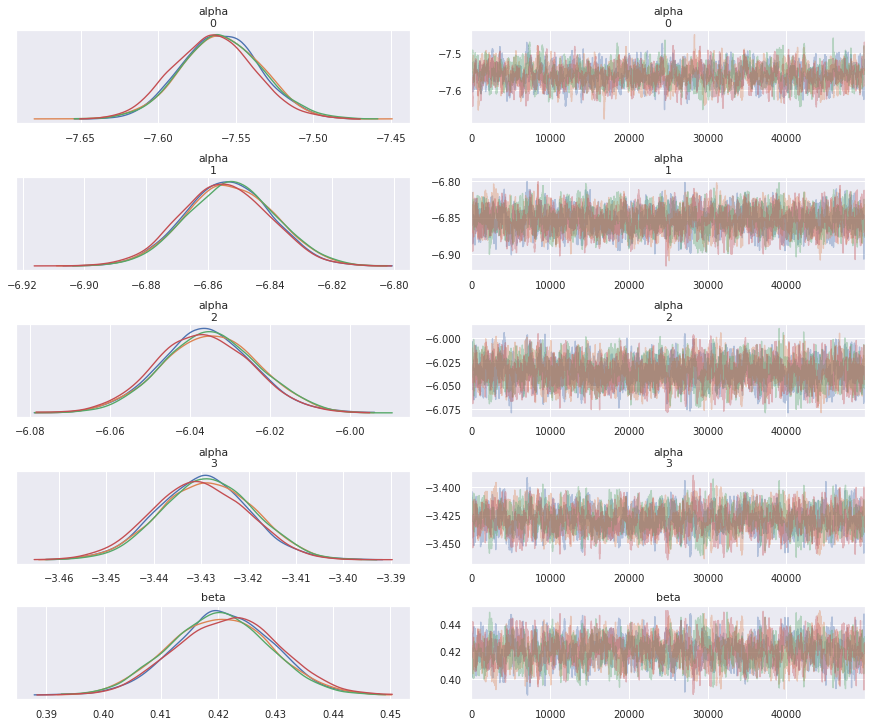

In [185]:
### control for age_grp by assigning a unique alpha to each age_grp,
# control for year/country by a unique beta per year/country

# model: 
# dead ~ Binomial(population,p)
# p = logit(alpha[age_idx] + beta[country_idx])
# alpha[age_idx] ~ Normal(0,10)
# beta[country_idx] ~ Normal(0,10)

age_idx = df['age_idx']
country_idx = df['country_index']

model = pm.Model()

with model:

    alpha = pm.Normal('alpha',0, sd=10,shape=4) #4 age groups

    beta = pm.Normal('beta',0,sd=10) # two countries

    

    # index for alpha : subtract 1 from age_idx that goes 1..4 to get zero-based index of python

    logit_age = np.exp(alpha[age_idx-1] + beta * df['country_index']) / (
        1 + np.exp(alpha[age_idx-1] + beta * df['country_index']))

    lkh_age = pm.Binomial('lkh_age',n=df['pop'],p=logit_age,observed=df['dead'])   
    
    step1 = pm.Metropolis([alpha,beta])

    trace = pm.sample(50000,step1,tune=10000,chains=4,cores=4)
    
    _= az.plot_trace(trace)
    print (az.summary(trace,round_to=2))
    
    

In [186]:
alpha_inf = trace['alpha'][:,0]
alpha_child = trace['alpha'][:,1]
alpha_adult = trace['alpha'][:,2]
alpha_old = trace['alpha'][:,3]

beta = trace['beta'][:]



result = pd.DataFrame({'alpha_inf' : alpha_inf,
                        'alpha_child' : alpha_child,
                      'alpha_adult' : alpha_adult,
                       'alpha_old' : alpha_old,
                      'beta' : beta})

result.describe()

,alpha_inf,alpha_child,alpha_adult,alpha_old,beta
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,-7.560486,-6.853388,-6.035595,-3.429286,0.420770
std,0.025799,0.014129,0.011778,0.009725,0.008712
min,-7.679853,-6.916252,-6.078956,-3.465226,0.387900
25%,-7.577985,-6.862956,-6.043580,-3.435935,0.414814
50%,-7.560782,-6.853458,-6.035684,-3.429299,0.420778
75%,-7.543163,-6.843834,-6.027583,-3.422640,0.426713
max,-7.449269,-6.800509,-5.989531,-3.389698,0.450328


In [187]:
p_result = pd.DataFrame()

p_result['inf_p'] = logit_pure(result['alpha_inf'] + result['beta'])
p_result['child_p'] = logit_pure(result['alpha_child'] + result['beta'])
p_result['adult_p'] = logit_pure(result['alpha_adult'] + result['beta'])
p_result['old_p'] = logit_pure(result['alpha_old'] + result['beta'])

p_result.describe()
                                                            
                                                            


,inf_p,child_p,adult_p,old_p
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.000793,0.001606,0.003630,0.047043
std,0.000018,0.000014,0.000024,0.000132
min,0.000713,0.001545,0.003532,0.046482
25%,0.000780,0.001596,0.003614,0.046954
50%,0.000792,0.001606,0.003630,0.047043
75%,0.000804,0.001615,0.003647,0.047132
max,0.000869,0.001667,0.003724,0.047618


In [188]:
mortality

age_grp,adult,child,inf,old,all
country,,,,,
A,0.003636,0.001167,0.001,0.048,0.009867
B,0.005455,0.004200,0.001,0.050,0.005142
